In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Path to files
df = pd.read_csv('all_drinks.csv')

In [3]:
# Here he removes the first column "Unnamed" from both DataFrame and list of columns

cols = df.columns
cols = cols[1:]
data = np.array(df)[:,1:]
df = pd.DataFrame(np.array(df)[:,1:])
df.columns = cols

In [4]:
# Here he extract the columns containing ingredients (apparently there are many columns for ingredients)

ingredient_indices = cols[8:23]
ingredients = data[:,8:23]

In [5]:
categories = np.array(df['strCategory'])
unique_categories = np.unique(categories)
unique_categories

array(['Beer', 'Cocktail', 'Cocoa', 'Coffee / Tea', 'Homemade Liqueur',
       'Milk / Float / Shake', 'Ordinary Drink', 'Other/Unknown',
       'Punch / Party Drink', 'Shot', 'Soft Drink / Soda'], dtype=object)

In [6]:
ingredients

array([['Creme de Cacao', nan, nan, ..., nan, nan, nan],
       ['Absolut Kurant', nan, nan, ..., 'Cranberry juice',
        'Pineapple juice', nan],
       ['Lager', nan, nan, ..., nan, nan, nan],
       ...,
       ['Beer', nan, nan, ..., 'Lemon', nan, nan],
       ['Vodka', nan, nan, ..., nan, nan, nan],
       ['Sambuca', nan, nan, ..., nan, nan, nan]], dtype=object)

## WordClouds

In [7]:
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

In [8]:
punctuation = string.punctuation + '…'

def map_punctuation(s):
    return np.array([char not in punctuation for char in s])

token_arrays = np.empty(len(unique_categories),object)
token_arrays.fill([])

In [9]:
# Ingredients is extracted and joined together.

for i, row in enumerate(data):
    cat_i = np.where(unique_categories == row[4])[0][0] # This line finds which index in unique_categories, this is. row[4] is the category in the row
    s = ingredients[i] # s is the ingredients
    s = [i for i in s if isinstance(i, str)]
    s = ' '.join(s)
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[cat_i] = np.append(token_arrays[cat_i], token)

In [10]:
# We now have an array of arrays. Each array corresponds to a category in unique_categories
# I.e. token_arrays[0] corresponds to all the words in Ingredients for unique_categories[0] which is "Beer"

token_arrays[0]

array(['lager', 'tequila', 'ale', 'guinness', 'stout', 'guinness',
       'stout', 'root', 'beer', 'corona', 'bacardi', 'limon', 'lager',
       'campari', 'corona', 'light', 'rum', 'lager', 'cider',
       'blackcurrant', 'cordial', 'cider', 'lager', 'blue', 'curacao',
       'vodka', 'kahlua', 'guinness', 'stout', 'corona', 'bacardi',
       'limon', 'beer', 'amaretto', 'orange', 'juice', 'lager', 'cider',
       'lager', 'cider', 'blackcurrant', 'squash'], dtype='<U32')

In [11]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))

In [12]:
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp

In [13]:
tf_idfs[:10]

[[('lager', 0.2603481712895563),
  ('stout', 0.13017408564477814),
  ('guinness', 0.13017408564477814),
  ('corona', 0.13017408564477814),
  ('cider', 0.09404523840642709),
  ('blackcurrant', 0.08678272376318542),
  ('limon', 0.06169689079118699),
  ('bacardi', 0.06169689079118699),
  ('squash', 0.04339136188159271),
  ('beer', 0.03661105781918855),
  ('cordial', 0.030848445395593494),
  ('campari', 0.030848445395593494),
  ('root', 0.018305528909594276),
  ('curacao', 0.018305528909594276),
  ('blue', 0.018305528909594276),
  ('ale', 0.018305528909594276),
  ('tequila', 0.010968393115607558),
  ('light', 0.010968393115607558),
  ('kahlua', 0.008178943547665341),
  ('juice', 0.00576261242359506),
  ('amaretto', 0.00576261242359506),
  ('vodka', 0.0036312573216208417),
  ('rum', 0.0017246952149260449),
  ('orange', 0.0017246952149260449)],
 [('gin', 0.08517304610393396),
  ('grenadine', 0.06920309995944635),
  ('vermouth', 0.06286098307026598),
  ('juice', 0.05610392472783116),
  ('lime

In [14]:
from wordcloud import WordCloud

wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str)
    wordclouds.append(wordcloud)
    
    print(unique_categories[i])


Beer
Cocktail
Cocoa
Coffee / Tea
Homemade Liqueur
Milk / Float / Shake
Ordinary Drink
Other/Unknown
Punch / Party Drink
Shot
Soft Drink / Soda


## Ingredients-Categories

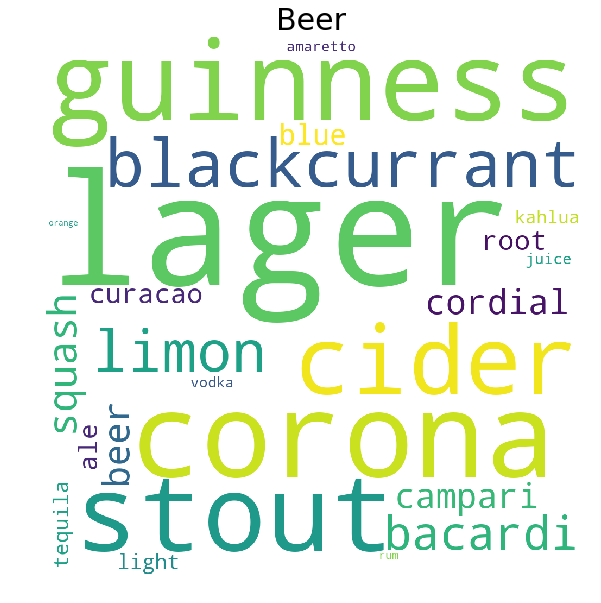

In [17]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[0]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[0], fontsize=30)

plt.show() 

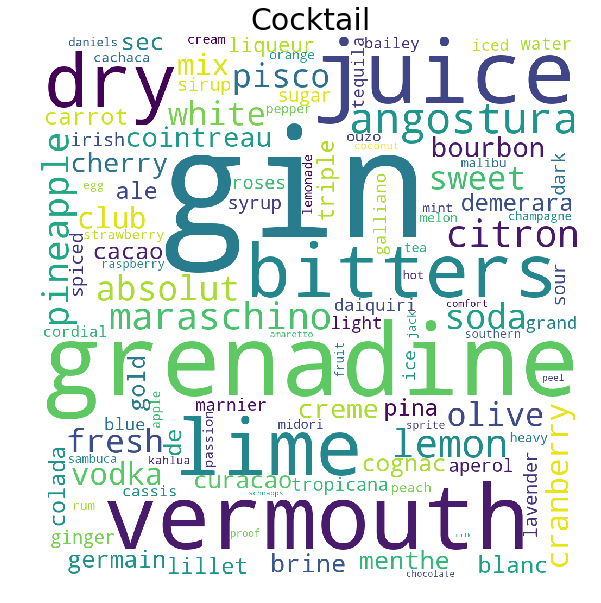

In [18]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[1]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[1], fontsize=30)

plt.show() 

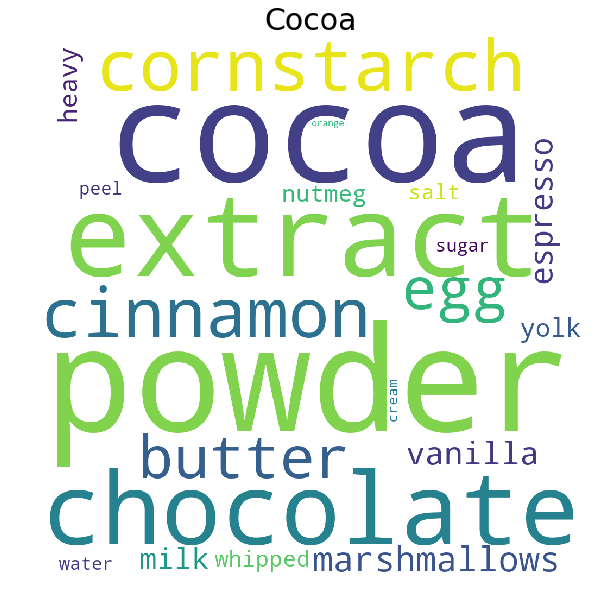

In [19]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[2]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[2], fontsize=30)

plt.show() 

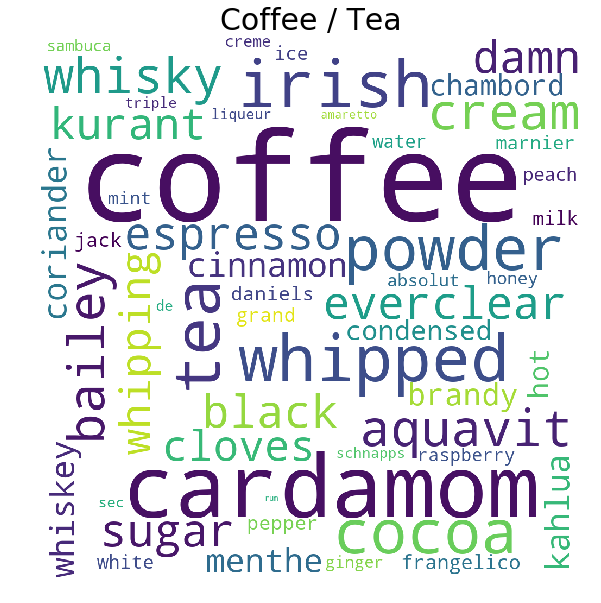

In [20]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[3]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[3], fontsize=30)

plt.show() 

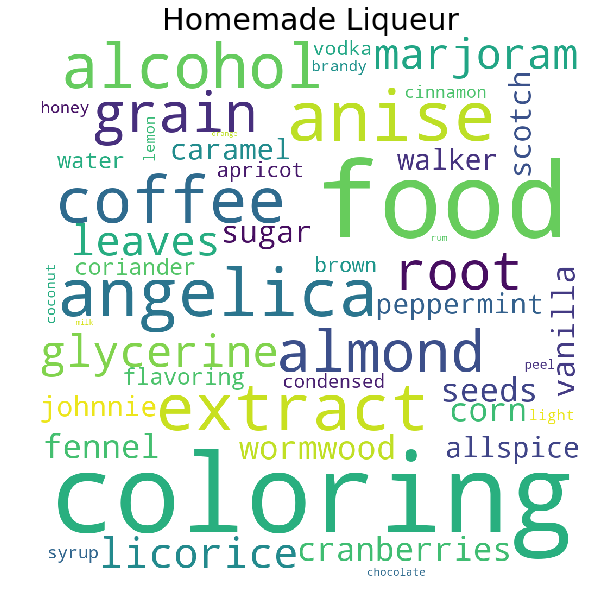

In [21]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[4]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[4], fontsize=30)

plt.show() 

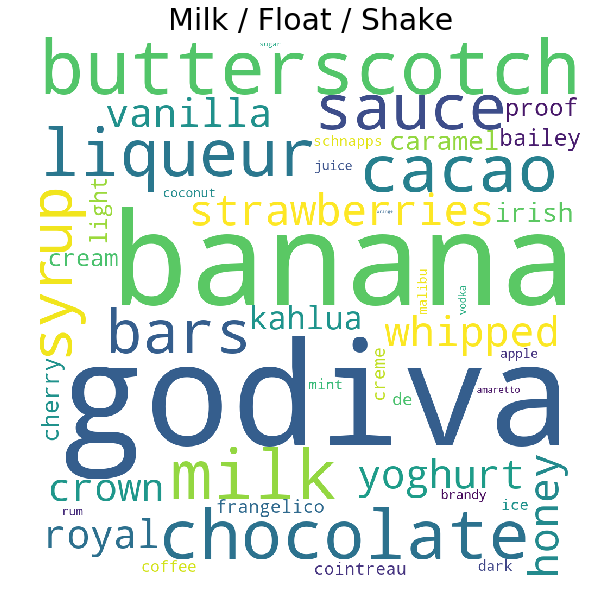

In [22]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[5]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[5], fontsize=30)

plt.show() 

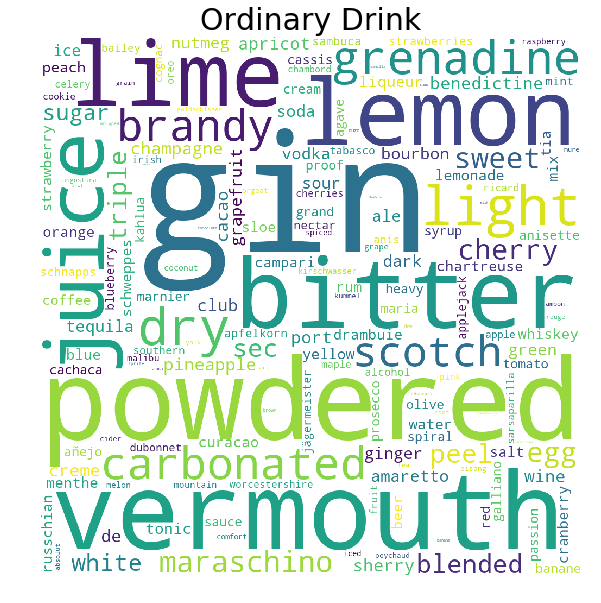

In [23]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[6]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[6], fontsize=30)

plt.show() 

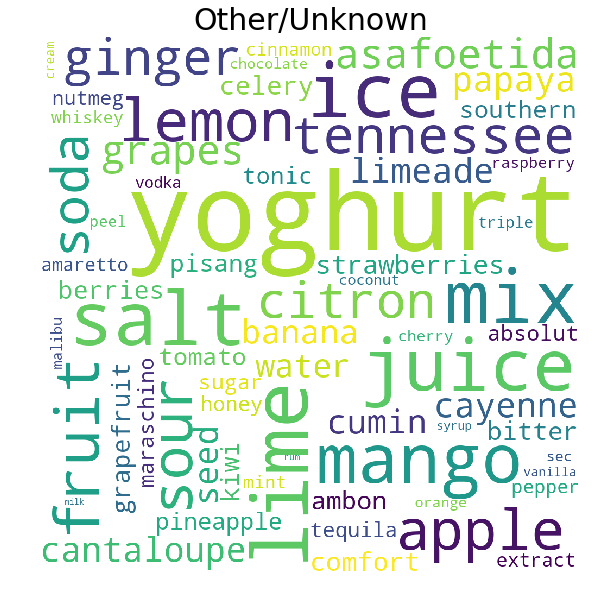

In [24]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[7]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[7], fontsize=30)

plt.show() 

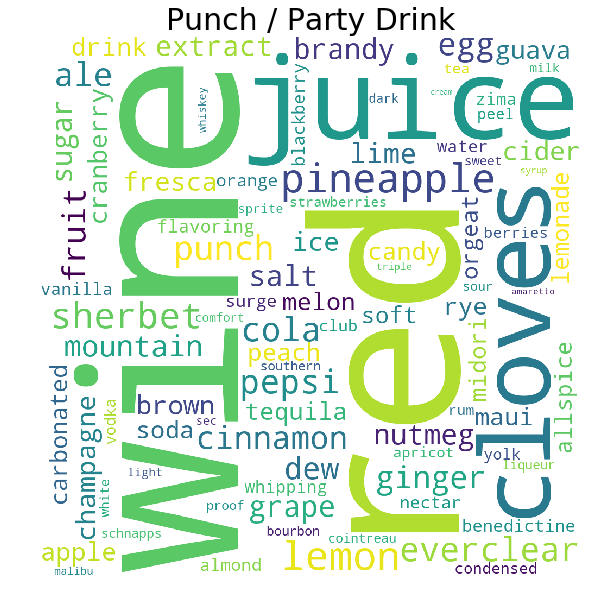

In [25]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[8]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[8], fontsize=30)

plt.show() 

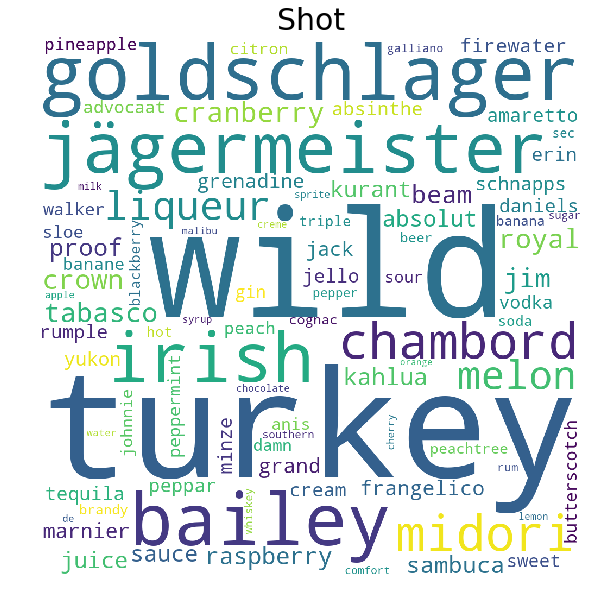

In [26]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[9]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[9], fontsize=30)

plt.show() 

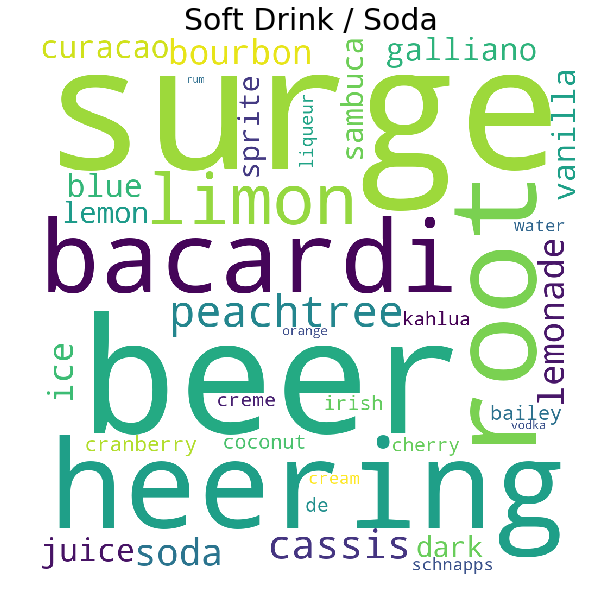

In [27]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[10]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_categories[10], fontsize=30)

plt.show() 